### Load Library

In [7]:
import pandas as pd
import numpy as np
import LightGBM as lgb
%matplotlib inline  

### Load Data as Dataframe

In [8]:
# Set data directory
dir = 'data/'

print('loading aisles')
aislesDF = pd.read_csv(dir + 'aisles.csv')

print('loading departments')
departmentsDF = pd.read_csv(dir + 'departments.csv')

print('loading order_products_prior')
order_products_priorDF = pd.read_csv(dir + 'order_products__prior.csv', dtype = {
    'order_id':np.int32,
    'product_id':np.uint16,
    'add_to_cart_order': np.int16,
    'reordered': np.int8
})

print('loading order_products_train')
order_products_trainDF = pd.read_csv(dir + 'order_products__train.csv', dtype = {
    'order_id':np.int32,
    'product_id':np.uint16,
    'add_to_cart_order': np.int16,
    'reordered': np.int8
})

print('loading orders')

ordersDF = pd.read_csv(dir + 'orders.csv', dtype = {
    'order_id': np.int32,
    'user_id': np.int32,
    'eval_set': 'category',
    'order_number': np.int16,
    'order_dow': np.int8,
    'order_hour_of_day': np.int8,
    'days_since_prior_order': np.float32
})

print('loading products')
productsDF = pd.read_csv(dir + 'products.csv', dtype = {
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8
})

loading aisles
loading departments
loading order_products_prior
loading order_products_train
loading orders
loading products


In [9]:
# Check datasets structure
print('aislesDF {}: {}'.format(aislesDF.shape, ', '.join(aislesDF.columns)))
print('departmentsDF {}: {}'.format(departmentsDF.shape, ', '.join(departmentsDF.columns)))
print('order_products_priorDF {}: {}'.format(order_products_priorDF.shape, ', '.join(order_products_priorDF.columns)))
print('order_products_trainDF {}: {}'.format(order_products_trainDF.shape, ', '.join(order_products_trainDF.columns)))
print('ordersDF {}: {}'.format(ordersDF.shape, ', '.join(ordersDF.columns)))
print('productsDF {}: {}'.format(productsDF.shape, ', '.join(productsDF.columns)))

aislesDF (134, 2): aisle_id, aisle
departmentsDF (21, 2): department_id, department
order_products_priorDF (32434489, 4): order_id, product_id, add_to_cart_order, reordered
order_products_trainDF (1384617, 4): order_id, product_id, add_to_cart_order, reordered
ordersDF (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
productsDF (49688, 4): product_id, product_name, aisle_id, department_id


### Get Features for Products

In [10]:
# products: productsDF joins products
# get reorder_rate = reordersTotal / ordersTotal
products_raw = pd.DataFrame()

products_raw['ordersTotal'] = order_products_priorDF.groupby(
    order_products_priorDF.product_id).size().astype(np.int32)

products_raw['reordersTotal'] = order_products_priorDF['reordered'].groupby(
    order_products_priorDF.product_id).sum().astype(np.float32)

products_raw['reorder_rate'] = (products_raw.reordersTotal / products_raw.ordersTotal).astype(np.float32)

products = productsDF.join(products_raw, on = 'product_id')
# products_new.set_index('product_id', drop = False, inplace = True)

# del products_raw

products.head()

,product_id,product_name,aisle_id,department_id,ordersTotal,reordersTotal,reorder_rate
0,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0,0.613391
1,2,All-Seasons Salt,104,13,90.0,12.0,0.133333
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0,0.732852
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0,0.446809
4,5,Green Chile Anytime Sauce,5,13,15.0,9.0,0.600000


### Get Features for Users

In [11]:
# priors: merge ordersDF to order_products_priorDF
ordersDF.set_index('order_id', inplace = True, drop = False)
priors = pd.merge(order_products_priorDF, ordersDF, how = 'left', on = 'order_id')

In [12]:
users = pd.DataFrame()
users['total_user'] = priors.groupby('product_id').size()
users['all_users'] = priors.groupby('product_id')['user_id'].apply(set)
users['total_distinct_users_perProduct'] = users.all_users.map(len)

In [13]:
users.head()

,total_user,all_users,total_distinct_users_perProduct
product_id,,,
1,1852,"{65537, 186370, 86020, 83973, 94215, 71688, 14...",716
2,90,"{201985, 45059, 38147, 180105, 89481, 110987, ...",78
3,277,"{128640, 180481, 96386, 202359, 197255, 14984,...",74
4,329,"{175106, 140804, 123909, 195589, 30213, 137222...",182
5,15,"{184864, 179876, 58825, 151922, 102105, 160220}",6


In [14]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [15]:
# customers: total_items, all_products, total_unique_items,
# avgDaysBetwOrders, NumberOfOrders, avg_per_cart
customers_raw = pd.DataFrame()
customers_raw['avgDaysBetwOrders'] = ordersDF.groupby(
    'user_id')['days_since_prior_order'].mean().astype(np.float32)

customers_raw['NumberOfOrders'] = ordersDF.groupby('user_id').size().astype(np.int16)

In [16]:
customers = pd.DataFrame()

customers['total_items'] = priors.groupby('user_id').size().astype(np.int16)
customers['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
customers['total_unique_items'] = customers.all_products.map(len).astype(np.float32)

customers = customers.join(customers_raw)
customers['avg_per_cart'] = (customers.total_items / customers.NumberOfOrders).astype(np.float32)

In [17]:
# del customers_raw
customers.head()

,total_items,all_products,total_unique_items,avgDaysBetwOrders,NumberOfOrders,avg_per_cart
user_id,,,,,,
1,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18.0,19.000000,11,5.363636
2,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102.0,16.285715,15,13.000000
3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33.0,12.000000,13,6.769231
4,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17.0,17.000000,6,3.000000
5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23.0,11.500000,5,7.400000


### Get Features for Users & Products

In [18]:
customerXproduct = priors.copy()
customerXproduct['user_product'] = (customerXproduct.product_id + 
                                    customerXproduct.user_id * 100000).astype(np.int64)

customerXproduct = customerXproduct.sort_values('order_number')

customerXproduct = customerXproduct.groupby('user_product', sort = False).agg(
{'order_id': ['size', 'last', 'first'], 'add_to_cart_order': 'sum'})

customerXproduct.columns = ['numbOfOrders', 'last_order_id', 'first_order_id','sum_add_to_cart_order']
customerXproduct.astype(
    {'numbOfOrders': np.int16, 'last_order_id': np.int32, 'first_order_id': np.int32, 'sum_add_to_cart_order': np.int16}, 
    inplace=True)

,numbOfOrders,last_order_id,first_order_id,sum_add_to_cart_order
user_product,,,,
8623906075,1,1520399,1520399,14
15429341329,1,2049062,2049062,3
15429323081,3,1489630,2049062,8
15429321527,3,2251505,2049062,14
15429335050,4,2251505,2049062,18
15429319893,1,2049062,2049062,7
15429309913,1,2049062,2049062,8
15429321903,1,2049062,2049062,9
15429342719,1,2049062,2049062,10


In [19]:
customerXproduct.head()

,numbOfOrders,last_order_id,first_order_id,sum_add_to_cart_order
user_product,,,,
8623906075,1,1520399,1520399,14
15429341329,1,2049062,2049062,3
15429323081,3,1489630,2049062,8
15429321527,3,2251505,2049062,14
15429335050,4,2251505,2049062,18


In [20]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


### Define a Function to Get All Needed Features

In [21]:
def get_features(specified_orders, given_labels = False):
    print('create initial empty list')
    orders_list = []
    products_list = []
    labels = []
    
    training_index = set(order_products_trainDF.index)
    
    for row in specified_orders.itertuples():
        user_id = row.user_id
        order_id = row.order_id
        
        user_products = customers['all_products'][user_id]
        products_list += user_products
        orders_list += [order_id] * len(user_products)
        
        if given_labels:
            labels += [(order_id, product) in training_index for product in user_products]
        
    DF = pd.DataFrame({'order_id': orders_list, 'product_id': products_list}, dtype = np.int32)
    labels = np.array(labels, dtype = np.int8)
        
    print('get features for user part')
    DF['user_id'] = DF.order_id.map(ordersDF.user_id)
    DF['user_total_orders'] = DF.user_id.map(customers.NumberOfOrders)
    DF['user_total_items'] = DF.user_id.map(customers.total_items)
    DF['total_unique_items'] = DF.user_id.map(customers.total_unique_items)
    DF['user_avgDaysBetwOrders'] = DF.user_id.map(customers.avgDaysBetwOrders)
    DF['user_avg_per_cart'] = DF.user_id.map(customers.avg_per_cart) 
        
    print('get features for order part')
#     DF['dow'] = DF.order_id.map(ordersDF.order_dow)
    DF['order_hour_of_day'] = DF.order_id.map(ordersDF.order_hour_of_day)
    DF['days_since_prior_order'] = DF.order_id.map(ordersDF.days_since_prior_order)
    DF['daysSincePrior_avgDaysBetw_ratio'] = DF.days_since_prior_order / DF.user_avgDaysBetwOrders
        
    print('get features for product part')
    DF['aisle_id'] = DF.product_id.map(products.aisle_id)
    DF['department_id'] = DF.product_id.map(products.department_id)
    DF['product_order'] = DF.product_id.map(products.ordersTotal)
    DF['product_reorder'] = DF.product_id.map(products.reordersTotal)
    DF['product_reorder_rate'] = DF.product_id.map(products.reorder_rate)
    DF['product_distinct_user'] = DF.product_id.map(users.total_distinct_users_perProduct)
    
    print('get features for customerXproduct')
    DF['user_product_id']  = (DF.product_id + DF.user_id * 100000).astype(np.int64)
    DF.drop(['user_id'], axis = 1, inplace = True)
    DF['CP_numOrders'] = DF.user_product_id.map(customerXproduct.numbOfOrders)
    DF['CP_orders_ratio'] = DF.CP_numOrders / DF.user_total_orders
    DF['CP_last_order_id'] = DF.user_product_id.map(customerXproduct.last_order_id)
    DF['CP_avg_pos_inCart'] = DF.user_product_id.map(customerXproduct.sum_add_to_cart_order) / DF.CP_numOrders
    DF['CP_order_since_last'] = DF.user_total_orders - DF.CP_last_order_id.map(ordersDF.order_number)
    DF['CP_hour_vs_last'] = abs(DF.order_hour_of_day - DF.CP_last_order_id.map(
    ordersDF.order_hour_of_day)).map(lambda x: min(x, 24 - x)).astype(np.int8)
#     DF['CP_order_rate_since_first'] = DF.CP_numOrders / (DF.user_total_orders - DF.user_product_id.map(customerXproduct.first_order_id))
    
    DF.drop(['CP_last_order_id', 'user_product_id'], axis = 1, inplace = True)
    return(DF, labels)
        

### Split Training and Test sets

In [22]:
test = ordersDF[ordersDF.eval_set == 'test']
train = ordersDF[ordersDF.eval_set == 'train']

order_products_trainDF.set_index(['order_id', 'product_id'], inplace = True, drop = False)

### Get Training Set Features and Labels

In [23]:
df_to_train, train_labels = get_features(train, given_labels=True)

create initial empty list
get features for user part
get features for order part
get features for product part
get features for customerXproduct


### Get Test Set Features

In [24]:
df_to_test, _ = get_features(test)

create initial empty list
get features for user part
get features for order part
get features for product part
get features for customerXproduct


### Get Important Features to Train the Model


In [25]:
# select features to use for training
features_to_use = ['user_total_orders', 'user_total_items', 'total_unique_items', 
                  'user_avgDaysBetwOrders', 'user_avg_per_cart', 'order_hour_of_day',
                  'days_since_prior_order', 'daysSincePrior_avgDaysBetw_ratio',
                  'aisle_id', 'department_id', 'product_order', 'product_reorder',
                  'product_reorder_rate', 'CP_numOrders', 'CP_orders_ratio', 
                  'CP_avg_pos_inCart', 'CP_order_since_last', 'CP_hour_vs_last',
                  'product_distinct_user'] #'dow'

### LightGBM Model Training

In [26]:
print('create lgb dataset')
d_train_lgb = lgb.Dataset(df_to_train[features_to_use],
                     label = train_labels,
                     categorical_feature = ['aisle_id', 'department_id'])


# Set parameters
lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}

ROUNDS = 80

create lgb dataset


training model


/Users/chenyun/anaconda/lib/python3.6/site-packages/LightGBM/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


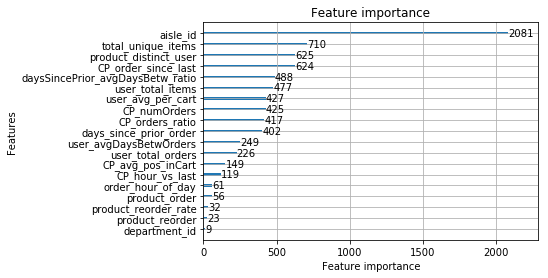

In [27]:
print('training model')
lgb_bst = lgb.train(lgb_params, d_train_lgb, ROUNDS)

# Plot importance of predictors
lgb.plot_importance(lgb_bst)

In [28]:
# Set threshold
# We get the threshold in cross validation
threshold = 0.2

In [29]:
print('predict on test data')
lgb_preds = lgb_bst.predict(df_to_test[features_to_use])

df_to_test['pred'] = lgb_preds

d = dict()
for row in df_to_test.itertuples():
    if row.pred > threshold:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']

sub.head()

predict on test data


,order_id,products
0,2774568,17668 21903 39190 47766 18599 43961 23650 24810
1,1528013,21903 38293
2,1376945,33572 28465 27959 44632 34658 14947 35948 8309...
3,1356845,14992 7076 28134 10863 13176
4,2161313,11266 196 10441 12427 37710 48142 14715 27839


### Convert sub to csv File and Submit to Kaggle

In [30]:
# print('saving csv')
# sub.to_csv('lightgbm_0.20(6th)_nodow.csv', index=False)